# Integro Differential Equations
Looking at Schaum, Jerono (2019), we can use the provided PDE for modeling the growth population. This results in the following Equation: 
$$
\frac{\partial n(m,t)}{\partial t} = 
- \frac{\partial}{\partial m} \left[ r_g(m, S) \, n(m, t) \right] 
- \Gamma(m, S) \, n(m, t) 
+ 2 \int_m^{m_{\text{max}}} \Gamma(m', S) \, p(m' \to m) \, n(m', t) \, dm' 
- D \, n(m, t)
$$
$$
\dot{S}(t) = - \int_0^{m^+} r_{g}(m, S) \, n(m, t) \, dm
$$
Note that when solving numerically, i do not use the chain rule for the derivative with regards to $m$ (even though i probably should...). Simply because it is easier to implement numerically and i enforce the assumption that the growth rate is independent of the cell mass. This assumption might not be accurate, however it simplifies the equation and apparently reduces the computational effort.
Therefore we make the approximation : 
$$
\frac{\partial}{\partial m} \left[ r_g \, n \right] 
\approx \frac{(r_g \, n)_i - (r_g \, n)_{i-1}}{\Delta m}
$$ 

Since $n=f(m,t)$ this numerically, we have to discretize the System over the mass-Domain with regards to $$\Delta m=m_{i}-m_{i-1}$$ and then solve it for small time increments $\Delta t$. Basically creating a System of ODEs for each incremental Distribution $n_{i}$

Now to make this look more "mathematical" i introduce :
$$
\begin{aligned}
& \Delta m = m_i - m_{i-1}  ,  i  \epsilon [0,M] \\
& n_i(t) \approx n(m_i, t) \\
& r_{g,i}(S) = r_g(m_i, S) \\
& \Gamma_i(S) = \Gamma(m_i, S) \\
& p_{k \to i} \approx p(m_k \to m_i)
\end{aligned}
$$
The integral term can be approximated by the sum over the increments,so that for each $n_{i}$ we can apply : 
$$
\frac{d n_i}{dt} = 
- \frac{(r_g \, n)_i - (r_g \, n)_{i-1}}{\Delta m}
- \Gamma_i(S) \, n_i
+ 2 \sum_{k=i}^{M} \Gamma_k(S) \, p_{k \to i} \, n_k \, \Delta m
- D \, n_i
$$
and also the additional condition for the Substrate :
$$
\frac{dS}{dt} = - \sum_{i=0}^{M} r_{g,i}(S) \, n_i \, \Delta m
$$

Now lets get to coding...



# Numeric Simulation

In [17]:
#imports
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import random #for random starting values around a mean value 

In [18]:
#domain and discretization
M  =  100
m_min,  m_max   =    0.0,    2.0 
m = np.linspace(m_min, m_max, M+1)
delta_m = m[1] - m[0]

In [19]:
#functions for growth rate/death rate...
def r_g (m_i, S):
    return 0.5 * S +0.01*m_i #assume independent of m_i (see above for reason)/ or slightly dependent on m_i

def Gamma(m_i):
    return 0.5*m_i**2 #assume rate of division is proportional to m_i^2 (randomly chosen here)

def p(k, i):
    if k > i :      #cells division can never lead to bigger cell size than the parent cell
        return 1.0 / (k + 1)        #the +1 is to avoid division by zero
    return 0.0

In [20]:
def population_system (t,y):
    n=y[:-1]
    S=y[-1] # Ensure S is non-negative
    
    dn_dt= np.zeros_like(n)
    r_g_values = r_g(m,S)
    Gamma_values=Gamma(m)
    
    # Compute the finite difference approximation for ∂/∂m (r_g * n)
    rg_n = r_g_values * n
    d_rg_n_dm = np.zeros_like(n)
    d_rg_n_dm[1:] = (rg_n[1:] - rg_n[:-1]) / delta_m
    d_rg_n_dm[0] = 0.0  # boundary condition or zero flux assumption


    # Now compute the RHS for each n_i
    for i in range(M+1):
        # Fragmentation sum
        frag_sum = 0.0
        for k in range(i, M+1):
            frag_sum += Gamma_values[k] * p(k, i) * n[k]
        frag_sum *= 2 * delta_m

        dn_dt[i] = -d_rg_n_dm[i] - Gamma_values[i] * n[i] + frag_sum #- D * n[i]

    # Substrate equation
    dS_dt = -np.sum(r_g_values * n) * delta_m

    if S<=0:
        dS_dt = 0

    return np.concatenate([dn_dt, [dS_dt]])



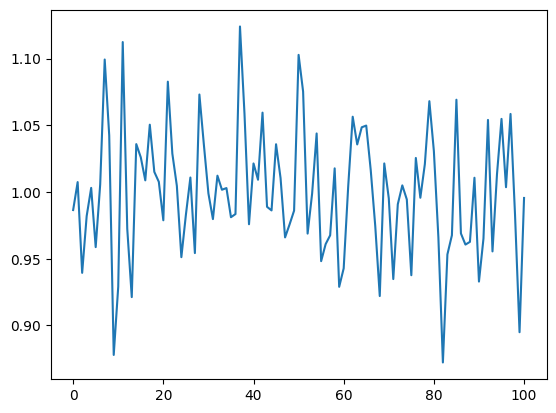

In [21]:
# Initial population n_i

n0 = [random.gauss(1.0, 0.05) for i in range(len(m))] #mean 1 , sigma=0.1
plt.plot(n0)

                 # Normalize

# Initial substrate S
S0 = 1.0

# Combine into single initial condition vector
y0 = np.concatenate([n0, [S0]])

In [22]:
t_span = (0.0, 10.0)
timesteps=200
t_eval = np.linspace(*t_span, timesteps)

sol = solve_ivp(population_system, t_span, y0, t_eval=t_eval, method='RK45')


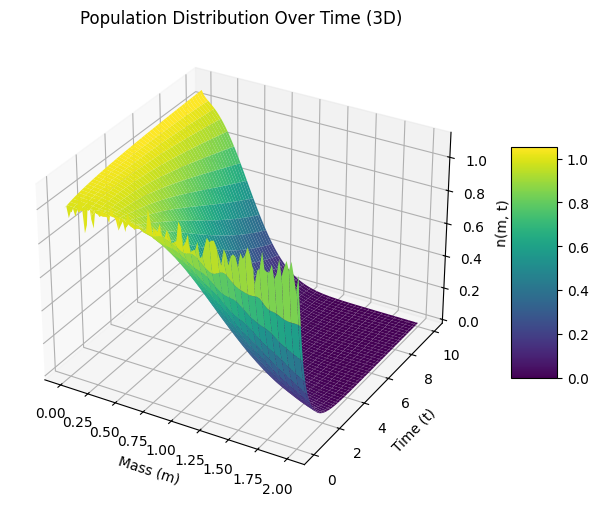

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

j=timesteps
# Create a meshgrid for mass (m) and time (t)
M_, T = np.meshgrid(m, sol.t[:j])  

# Extract corresponding n(m, t) values for the first j time points
N = sol.y[:-1, :j].T  # Transpose to match dimensions

# Create 3D plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot surface
surf = ax.plot_surface(M_, T, N, cmap='viridis')

ax.set_xlabel('Mass (m)')
ax.set_ylabel('Time (t)')
ax.set_zlabel('n(m, t)')
ax.set_title('Population Distribution Over Time (3D)')

# Add color bar
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

plt.show()

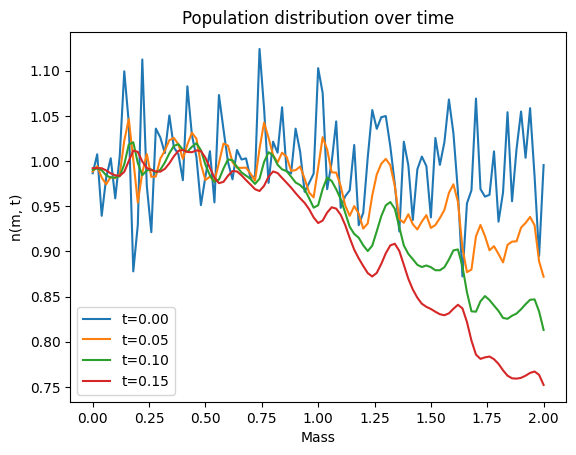

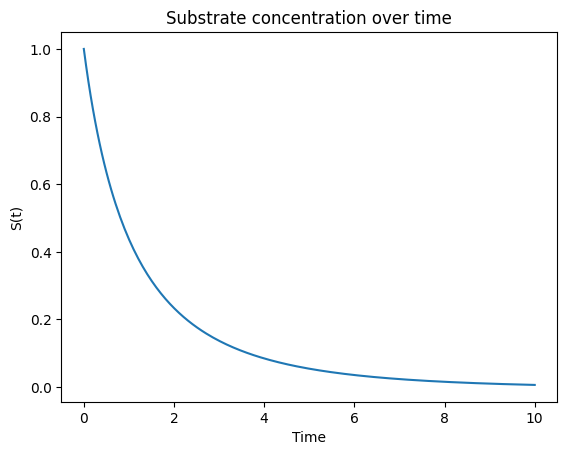

In [24]:


# Plot population distribution at different time steps
for idx in range(0,4):
    plt.plot(m, sol.y[:-1, idx], label=f't={sol.t[idx]:.2f}')
plt.xlabel('Mass')
plt.ylabel('n(m, t)')
plt.title('Population distribution over time')
plt.legend()
plt.show()

# Plot substrate over time
plt.plot(sol.t, sol.y[-1, :])
plt.xlabel('Time')
plt.ylabel('S(t)')
plt.title('Substrate concentration over time')
plt.show()


# Neural Network

In [25]:
'''
now we set up a neural network as a function f(n(m,t)) that serves sort of as a forward shift operator and allows us to get the 
value n(m, t+1). Since the System itself is not directly dependent on time, the training pairs for the model should be 
[n(m,t);n(m,t+1)],[n(m,t+1),n(m,t+2)]... 
the subsequent use of the function could then be used to compute the system state after an arbitrarily chosen time t, e.g
n(m,t+2)~   f(n(m,t+1))~    f(f(n(m,t)))
firstly we prepare the data: half the data will be used to train, the other half for validation
to access the solution at time t we use sol.y[:-1, t] with t being the timestep we evaluated the pde at
'''
import torch as torch 
import torch.nn as nn


Xtrain = sol.y[:-1, 0:int(timesteps/2)-1].T  # shape: (timesteps-1, 101)
X_train = sol.y[:-1, 1:int(timesteps/2)].T   # shape: (timesteps-1, 101)
dim=M+1         #number of mass increments from m_min to m_max



#initializing the neural network class that inherits from nn
class Neuralnetwork (nn.Module):
    def __init__(self,dim):
        super(Neuralnetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, dim)
        )
    def forward(self, x):
        return self.model(x)

model = Neuralnetwork(dim=dim)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss() #mean squared error loss function --randomly chosen, could also use weighted function
#weighted function may be good, to value the larger Cells more, since the measurement of these is generally more stable than 
#the measurement of small cells

X_tensor = torch.tensor(Xtrain, dtype=torch.float32)
print(X_tensor.shape)

Y_tensor = torch.tensor(X_train, dtype=torch.float32)
print(Y_tensor.shape)

for epoch in range(10000):
    optimizer.zero_grad()
    output = model(X_tensor)
    loss = criterion(output, Y_tensor)
    loss.backward()
    optimizer.step()
    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

solutions=[]
#for visualization we need to detach the tensors from the computational graph (graph tracks gradients for backpropagation,
#but we only care for the numbers for plotting)
n01_pred = (model(torch.tensor(n0, dtype=torch.float32))).detach().numpy()
n02_pred=model(torch.tensor(n01_pred,dtype=torch.float32)).detach().numpy()
n03_pred=model(torch.tensor(n02_pred,dtype=torch.float32)).detach().numpy()

# plt.plot(n0)
# plt.plot(n01_pred)
# plt.plot(n02_pred)
# plt.plot(n03_pred)

# plt.plot(sol.y[:-1,3]/n03_pred)



torch.Size([99, 101])
torch.Size([99, 101])
Epoch 0, Loss: 0.433169
Epoch 1000, Loss: 0.000027
Epoch 2000, Loss: 0.000011
Epoch 3000, Loss: 0.000007
Epoch 4000, Loss: 0.000010
Epoch 5000, Loss: 0.000005
Epoch 6000, Loss: 0.000003
Epoch 7000, Loss: 0.000003
Epoch 8000, Loss: 0.000015
Epoch 9000, Loss: 0.000002


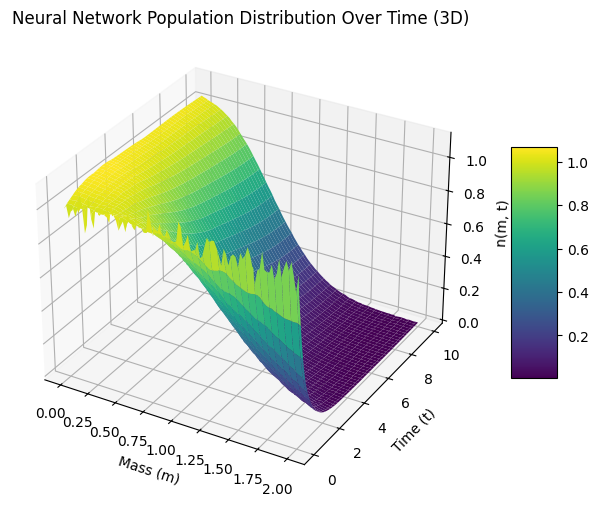

In [ ]:
# Now we can use the model to predict the population distribution at future timesteps
solution=[n0]
for i in range (0,timesteps-1):
    
    nprev=solution[i]
    ni=model(torch.tensor(nprev,dtype=torch.float32)).detach().numpy()
    solution.append(ni)


# Prepare meshgrid for plotting
timesteps_nn = len(solution)
T_nn, M_nn = np.meshgrid(t_eval[:timesteps_nn], m)

# Convert solution list to numpy array and transpose for correct shape
N_nn = np.array(solution)  # shape: (timesteps_nn, len(m))


# Create 3D plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot surface
surf = ax.plot_surface(M_nn.T, T_nn.T, N_nn, cmap='viridis')

ax.set_xlabel('Mass (m)')
ax.set_ylabel('Time (t)')
ax.set_zlabel('n(m, t)')
ax.set_title('Neural Network Population Distribution Over Time (3D)')

fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
plt.show()
    



# Error estimation
Note that we only used our Model for the first half of the dataset that we calculated using the PDE so i only care about the mistake in the "predicted" part of the Neural Network, not the part that i specifically used the training data on.

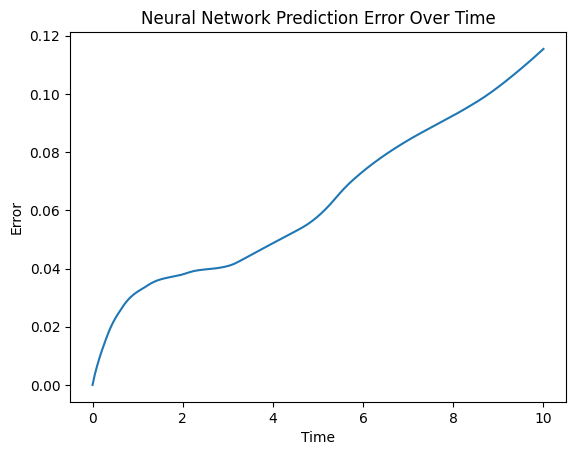

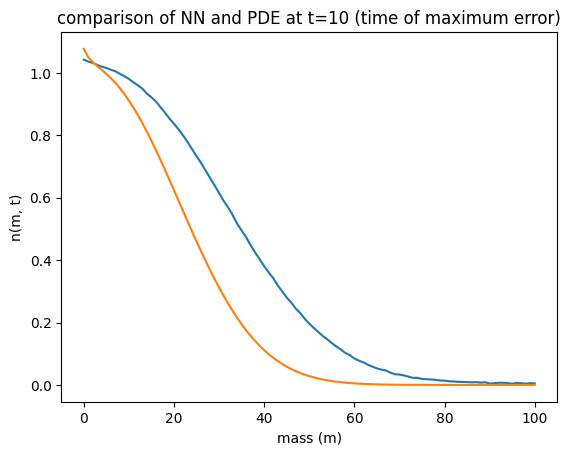

In [59]:
error=[]# Calculate the error between the neural network predictions and the original solution
for i in range(timesteps_nn):
    er=0
    
    for j in range (M+1):
        er+= np.linalg.norm(N_nn[i, j] - sol.y[:-1, i][j])/(M+1)
    error.append(er)


# Plot error over time as a separate plot
plt.figure()
plt.plot(t_eval[:timesteps], error)
plt.xlabel('Time')
plt.ylabel('Error')
plt.title('Neural Network Prediction Error Over Time')
plt.show()

#
plt.figure()
plt.title('comparison of NN and PDE at t=10 (time of maximum error)')
plt.plot(N_nn[199])
plt.plot(sol.y[:-1, 199])
plt.xlabel('mass (m)')
plt.ylabel('n(m, t)')  
plt.show()